We want to do a Hawkins+2017 style run, with $\varpi_{\rm zp}$ having a highly informed prior, and the RC parameters being free.

In [1]:
# !/bin/env python
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
sns.set_palette('colorblind')
matplotlib.rc('xtick', labelsize=15)
matplotlib.rc('ytick', labelsize=15)
matplotlib.rc('axes',labelsize=15)
matplotlib.rcParams['text.usetex'] = False

import pandas as pd
import pystan
import corner

import pickle
import glob

import os
import sys

__outdir__ = os.path.expanduser('~')+'/PhD/Gaia_Project/Output/Parallax_Runs/Testruns/'
__datdir__ = os.path.expanduser('~')+'/PhD/Gaia_Project/data/KepxDR2/'

In [2]:
overwrite = False
hawkstan = '''
functions {
    real bailerjones_lpdf(real r, real L){
        return log((1/(2*L^3)) * (r*r) * exp(-r/L));
    }
    real precalc_multinormal_lpdf(vector oo, vector oo_true, real logdetc, matrix invc, int N, real Nfloat){
        vector[N] r;
        r = oo - oo_true;

        return -0.5 * ((r' * invc * r) + logdetc + Nfloat * log(2*pi()));
    }
}
data {
    int<lower = 0> N;
    real<lower= 0> Nfloat;
    vector[N] m;
    vector<lower=0>[N] m_err;
    vector[N] oo;
    vector<lower=0>[N] RlEbv;

    matrix[N, N] invc;
    real logdetc;

    real oozp_init;
    real oozp_spread;
    real muH;
}
parameters {
    //Hyperparameters
    real mu;
    real<lower=0.> sigma;
    real<lower=1.> sigo;
    real<lower=0.5,upper=1.> Q;
    real<lower=.1, upper=4000.> L;
    real oo_zp;

    //Latent parameters
    vector[N] M_infd_std;
    vector[N] Ai;
    vector<lower = 1.>[N] r_infd;
}
transformed parameters{
    //Inferred and transformed parameters
    vector[N] M_infd;

    //Operations
    for (n in 1:N){
        M_infd[n] = mu + sigma * M_infd_std[n]; //Rescale the M fit
    }
}
model {
    //Define calculable properties
    vector[N] m_true;
    vector[N] oo_true;

    //Hyperparameters [p(theta_rc, L)]
    mu ~ normal(muH, 1.0); // Prior from seismo
    sigma ~ normal(0.0, 1.0);
    Q ~ normal(1., .25);
    sigo ~ normal(3.0, 1.0);
    L ~ uniform(0.1, 4000.);   // Prior on the length scale
    oo_zp ~ normal(oozp_init, oozp_spread); // Prior on the offset (in mu as)

    //Latent parameters [p(alpha_i | theta_rc, L)]
    Ai ~ normal(RlEbv, 0.05);
    for (n in 1:N){
        r_infd[n] ~ bailerjones(L);
        target += log_mix(Q,
            normal_lpdf(M_infd_std[n] | 0., 1.),
            normal_lpdf(M_infd_std[n] | 0., sigo));
    }

    //Calculable properties
    for (n in 1:N){
        m_true[n] = M_infd[n] + 5*log10(r_infd[n]) - 5 + Ai[n];
        oo_true[n] = (1000./r_infd[n]) + (oo_zp/1000.);
    }

    //Observables [p(D | theta_rc, L, alpha)]
    oo ~ precalc_multinormal(oo_true, logdetc, invc, N, Nfloat);
    m ~ normal(m_true, m_err); //Measurement uncertainty on magnitude
}

'''
model_path = 'hawkstan.pkl'
if overwrite:
    print('Updating Stan model')
    sm = pystan.StanModel(model_code = hawkstan, model_name='hawkstan')
    with open(model_path, 'wb') as f:
        pickle.dump(sm, f)
else:
    if os.path.isfile(model_path):
        print('Loading in existing Stan Model') 
        sm = pickle.load(open(model_path, 'rb'))
    else:
        print('Saving Stan Model') 
        sm = pystan.StanModel(model_code = hawkstan, model_name='hawkstan')
        with open(model_path, 'wb') as f:
            pickle.dump(sm, f)

Loading in existing Stan Model


In [3]:
def read_data():
    sfile = __datdir__+'rcxyu18.csv'
    df = pd.read_csv(sfile)
    return df

def kernel(ra, dec, sigma, p):
    '''
    p[0] : Offset
    p[1] : Exponential decay scale
    '''
    dr = np.deg2rad(dec)
    thetaij = np.sqrt((np.subtract.outer(ra, ra)*np.cos(0.5*np.add.outer(dr, dr)))**2 + np.subtract.outer(dec, dec)**2)
    cov = p[0] * np.exp(-thetaij / p[1]) + p[2] * np.exp(-thetaij / 0.3)
    np.fill_diagonal(cov, np.diag(cov) + sigma**2)

    if not np.all(np.linalg.eigvals(cov) > 0):
        raise ValueError("The matrix isn't positive-definite for some reason!")
    return cov

def get_covmatrix(df):
    p = [285*10**-6, 14., 1565*10**-6, 0.3]
    Sigma = kernel(df.ra.values, df.dec.values, df.parallax_error.values, p)
    invc = np.linalg.inv(Sigma)
    logdetc = np.linalg.slogdet(Sigma)[1] * np.linalg.slogdet(Sigma)[0]

    return Sigma, invc, logdetc

We've added a term that reads as

$1565\ \mu\rm as^2 \times \exp(-\theta_{ij}/0.3\ \rm{deg})$

To account for the low separation variability. This allows for a total increased variance of $1850\ \mu\rm as^2$ at $\theta_{ij} = 0$, as presented in [Lindegren's presentation of known issues in Gaia](https://www.cosmos.esa.int/documents/29201/1770596/Lindegren_GaiaDR2_Astrometry_extended.pdf/1ebddb25-f010-6437-cb14-0e360e2d9f09).

In [5]:
kdf = read_data()
from sklearn.utils import shuffle
df = shuffle(kdf, random_state=24601)[:1000].reset_index()

>13G : 402
<13G : 598


/usr/local/lib/python2.7/dist-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/oliver/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


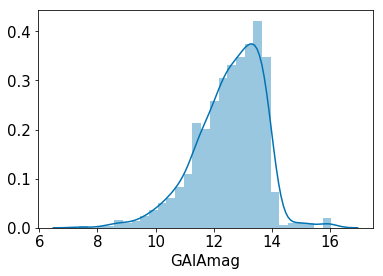

In [6]:
print('>13G : {}'.format(len(np.where(df.GAIAmag.values > 13)[0])))
print('<13G : {}'.format(len(np.where(df.GAIAmag.values < 13)[0])))
sns.distplot(df.GAIAmag)
plt.show()

In [7]:
Sigma, invc, logdetc = get_covmatrix(df)


In [8]:
from omnitool.literature_values import hawkvals

band = 'GAIA'
if band == 'K':
    rlebv = df.Aks.values
    mband = df.Kmag.values
    merr = df.e_Kmag.values
elif band == 'GAIA':
    rlebv = df.Ebv.values * 2.740 #As per Casagrande & Vandenberg 2018b
    #Correct the Gaia G mags as per Casagrande & Vandenberg 2018b
    mband = np.ones(len(df)) * df.GAIAmag.values
    sel = (mband > 6.) & (mband < 16.5)
    mband[sel] = 0.0505 + 0.9966*mband[sel]
    merr = np.ones(len(mband)) * 10.e-3 #Setting precision to 10mmag by default

dat = {'N':len(df),
       'Nfloat':np.float(len(df)),
        'm': mband,
        'm_err': merr,
        'oo': df.parallax.values,
        'RlEbv': rlebv,
        'logdetc': logdetc,
        'invc': invc,
        'muH': hawkvals[band],
        'oozp_init' : 0.,
        'oozp_spread' : 1000.}


init= {'mu': hawkvals[band],
        'sigma': 0.1,
        'Q': 0.95,
        'sigo': 4.,
        'L': 1000.,
        'oozp':0.,
        'r_infd':df.r_est,
        'Ai':rlebv}

pars = ['mu', 'sigma', 'Q', 'sigo', 'L', 'oo_zp']
verbose = [r'$\mu_{RC} (mag)$',r'$\sigma_{RC} (mag)$',r'$Q$', r'$\sigma_o (mag)$', r'$L (pc)$', r'$\varpi_{zp} (\mu as)$']

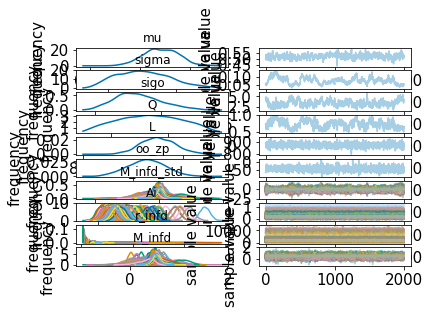

In [9]:
runlabel = __outdir__+band+'_fullframe'

fit = sm.sampling(data = dat, iter = 1000, chains=4, seed = 24601,
                    init = [init for i in range(4)])
chain = np.array([fit[label] for label in pars])
np.savetxt(runlabel+'_chains.txt', chain)

pardict = {label:np.median(fit[label]) for label in pars}
pardict.update({label+'_std':np.std(fit[label]) for label in pars})
pardict = pd.DataFrame.from_dict(pardict, orient='index').T
pardict.to_csv(runlabel+'_pars.csv')

s = fit.summary()
rhat = s['summary'][:,-1]
np.savetxt(runlabel+'_rhats.txt',rhat)

corner.corner(chain.T, labels=verbose,quantiles=[0.16, 0.5, 0.84],show_titles=True, title_kwargs={"fontsize":12})
plt.savefig(runlabel+'_corner.png')
plt.close()

fit.plot()
plt.show()